In [1]:
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
mdt=pd.read_excel("Medtronic plc.xlsx")

In [5]:
mdt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Apr 28, 2025",84.60,84.88,83.39,83.49,83.49,1978467
1,"Apr 25, 2025",84.41,84.66,83.50,84.16,84.16,5879600
2,"Apr 24, 2025",84.03,84.54,83.26,84.30,84.30,5959000
3,"Apr 23, 2025",84.16,85.35,83.36,83.75,83.75,6468200
4,"Apr 22, 2025",82.81,83.62,82.50,83.37,83.37,5284900


In [6]:
mdt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [7]:
mdt.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Time Series Analysis

In [8]:
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = 50, ax = ax_acf)
    plot_pacf(xt, lags = 50, ax = ax_pacf)
    plt.tight_layout()
    return None

In [9]:
mdt

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Apr 28, 2025",84.60,84.88,83.39,83.49,83.49,1978467
1,"Apr 25, 2025",84.41,84.66,83.50,84.16,84.16,5879600
2,"Apr 24, 2025",84.03,84.54,83.26,84.30,84.30,5959000
3,"Apr 23, 2025",84.16,85.35,83.36,83.75,83.75,6468200
4,"Apr 22, 2025",82.81,83.62,82.50,83.37,83.37,5284900
...,...,...,...,...,...,...,...
1252,"May 4, 2020",94.53,95.70,93.61,95.26,82.52,4717600
1253,"May 1, 2020",97.00,97.18,94.60,95.14,82.41,4172000
1254,"Apr 30, 2020",98.13,99.44,96.85,97.63,84.57,5497000
1255,"Apr 29, 2020",99.50,100.79,98.73,99.14,85.88,5393600


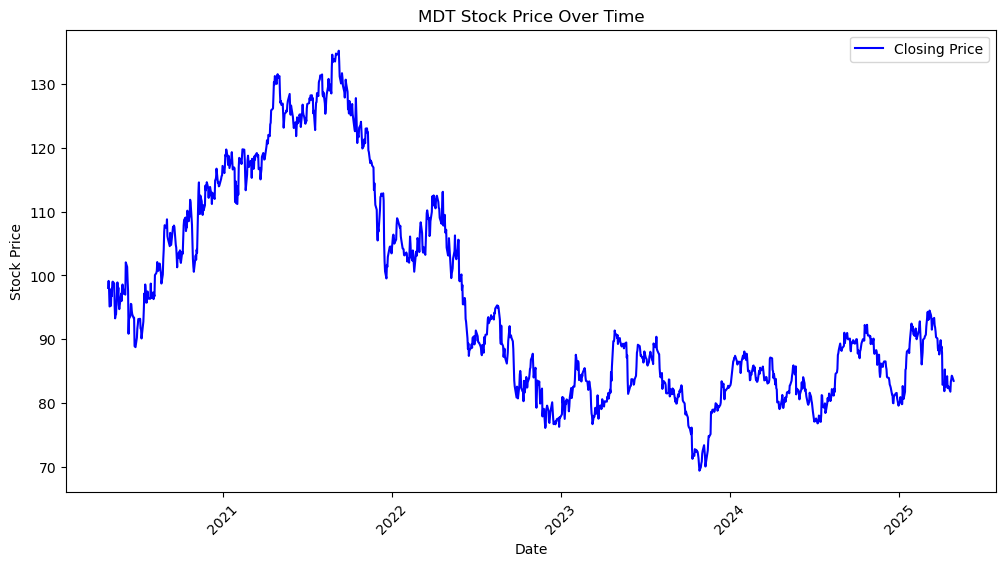

In [10]:
mdt['Date'] = pd.to_datetime(mdt['Date'])
mdt = mdt.sort_values(by='Date')
plt.figure(figsize=(12, 6))
plt.plot(mdt['Date'], mdt['Close'], label="Closing Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("MDT Stock Price Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [11]:
train = int(0.8 * len(mdt))
train, test = mdt[:train], mdt[train:]

train.shape, test.shape

((1005, 7), (252, 7))

# Predict Historical Mean

In [12]:
# Calculate the average of the training data
historical_mean = np.mean(train['Close'])
historical_mean

98.87844776119402

In [13]:
# Add a new column named as 'pred_mean' into test dataframe
test.loc[:, 'pred_mean'] = historical_mean
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean
251,2024-04-25,80.04,80.35,78.78,79.25,76.66,5624100,98.878448
250,2024-04-26,79.40,79.85,78.95,79.74,77.13,5024900,98.878448
249,2024-04-29,79.62,81.12,79.52,80.86,78.22,6029700,98.878448
248,2024-04-30,80.02,80.68,79.76,80.24,77.62,6487200,98.878448
247,2024-05-01,79.99,81.73,79.99,80.89,78.25,5366100,98.878448


In [14]:
# Method to calculate the predicted percentage of the dataframe
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
# Calculate the value based on the orignal and predicted data values
mape_hist_mean = mape(test['Close'], test['pred_mean'])
mape_hist_mean

15.802988131279507

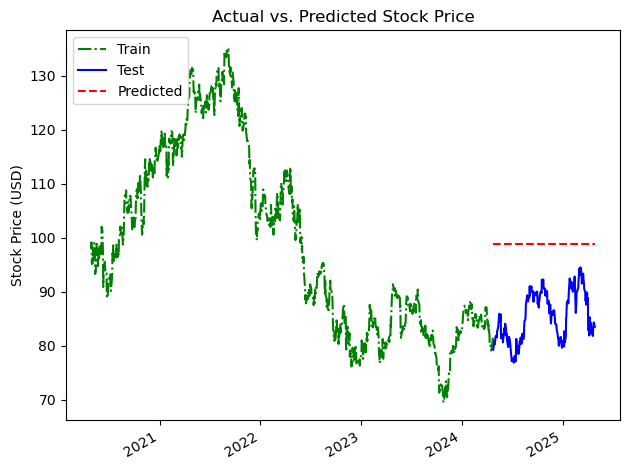

In [16]:
fig, ax = plt.subplots()

ax.plot(train['Date'], train['Close'], 'g-.', label = 'Train')
ax.plot(test['Date'], test['Close'], 'b-', label = 'Test')
ax.plot(test['Date'], test['pred_mean'], 'r--', label = 'Predicted')
ax.set_ylabel("Stock Price (USD)") 
ax.set_title("Actual vs. Predicted Stock Price") 
ax.legend(loc = 2)

fig.autofmt_xdate()
plt.tight_layout()

# Predict Last Year Mean

In [17]:
# Predict the last year mean values
last_year_mean = np.mean(train['Close'][-4:])
last_year_mean

80.43

In [18]:
# Add a new column to the last year mean value
test.loc[:, 'pred__last_yr_mean'] = last_year_mean

test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean,pred__last_yr_mean
251,2024-04-25,80.04,80.35,78.78,79.25,76.66,5624100,98.878448,80.43
250,2024-04-26,79.40,79.85,78.95,79.74,77.13,5024900,98.878448,80.43
249,2024-04-29,79.62,81.12,79.52,80.86,78.22,6029700,98.878448,80.43
248,2024-04-30,80.02,80.68,79.76,80.24,77.62,6487200,98.878448,80.43
247,2024-05-01,79.99,81.73,79.99,80.89,78.25,5366100,98.878448,80.43


In [19]:
# Calculate the last year mean and the 'data' column
mape_last_year_mean = mape(test['Close'], test['pred__last_yr_mean'])
mape_last_year_mean

6.328687537854398

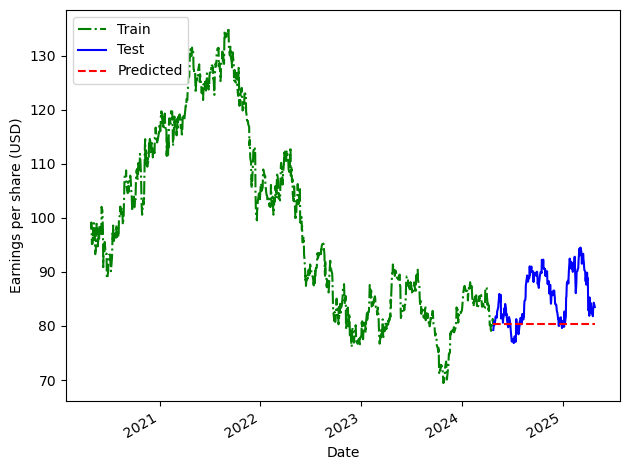

In [20]:
fig, ax = plt.subplots()
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
ax.plot(train['Date'], train['Close'], 'g-.', label='Train')
ax.plot(test['Date'], test['Close'], 'b-', label='Test')
ax.plot(test['Date'], test['pred__last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

ax.legend(loc = 2)

fig.autofmt_xdate()
plt.tight_layout()

# Predict Last Know Value

In [21]:
last = train['Close'].iloc[-4]
last

79.48

In [22]:
test.loc[:, 'pred_last'] = last

test

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean,pred__last_yr_mean,pred_last
251,2024-04-25,80.04,80.35,78.78,79.25,76.66,5624100,98.878448,80.43,79.48
250,2024-04-26,79.40,79.85,78.95,79.74,77.13,5024900,98.878448,80.43,79.48
249,2024-04-29,79.62,81.12,79.52,80.86,78.22,6029700,98.878448,80.43,79.48
248,2024-04-30,80.02,80.68,79.76,80.24,77.62,6487200,98.878448,80.43,79.48
247,2024-05-01,79.99,81.73,79.99,80.89,78.25,5366100,98.878448,80.43,79.48
...,...,...,...,...,...,...,...,...,...,...
4,2025-04-22,82.81,83.62,82.50,83.37,83.37,5284900,98.878448,80.43,79.48
3,2025-04-23,84.16,85.35,83.36,83.75,83.75,6468200,98.878448,80.43,79.48
2,2025-04-24,84.03,84.54,83.26,84.30,84.30,5959000,98.878448,80.43,79.48
1,2025-04-25,84.41,84.66,83.50,84.16,84.16,5879600,98.878448,80.43,79.48


In [23]:
mape_last = mape(test['Close'], test['pred_last'])
mape_last

7.18463948229011

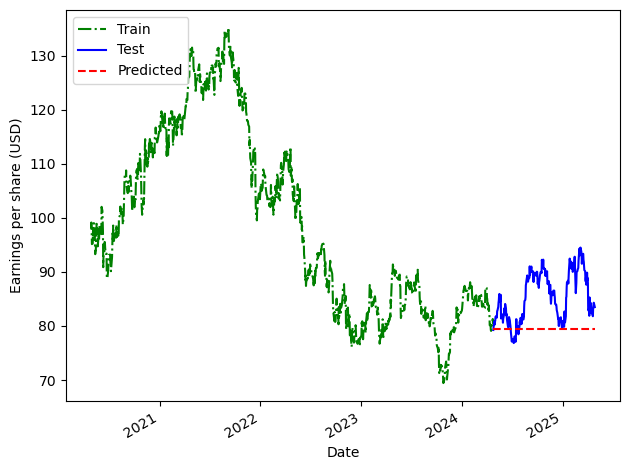

In [24]:
fig, ax = plt.subplots()

ax.plot(train['Date'], train['Close'], 'g-.', label='Train')
ax.plot(test['Date'], test['Close'], 'b-', label='Test')
ax.plot(test['Date'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

# Naive Seasonal Forecast

In [25]:
test.loc[:, 'pred_last_season'] = train['Close'][-252:].values
test.loc

In [26]:
mape_naive_seasonal = mape(test['Close'], test['pred_last_season'])
mape_naive_seasonal

8.12015902156082

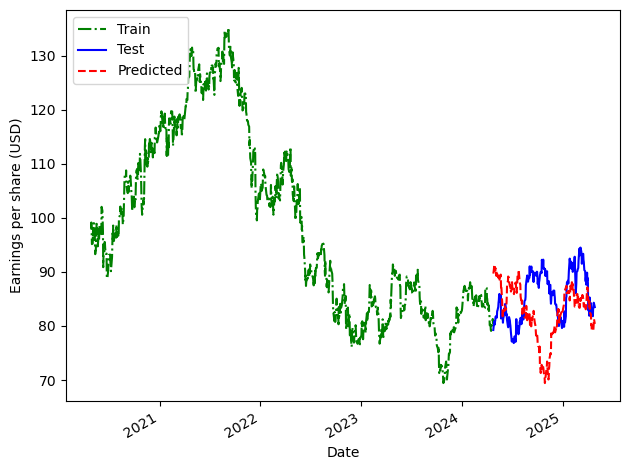

In [27]:
fig, ax = plt.subplots()

ax.plot(train['Date'], train['Close'], 'g-.', label='Train')
ax.plot(test['Date'], test['Close'], 'b-', label='Test')
ax.plot(test['Date'], test['pred_last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

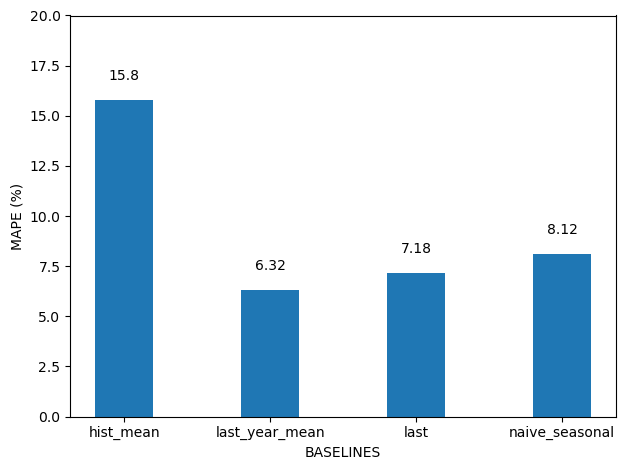

In [28]:
fig, ax = plt.subplots()

x = ['hist_mean', 'last_year_mean', 'last', 'naive_seasonal']
y = [15.80, 6.32, 7.18, 8.12]

ax.bar(x, y, width=0.4)
ax.set_xlabel('BASELINES')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 20)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(value), ha='center')

plt.tight_layout()

# ARIMA

In [29]:
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = 50, ax = ax_acf)
    plot_pacf(xt, lags = 50, ax = ax_pacf)
    plt.tight_layout()
    return None

In [30]:
mdt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1256,2020-04-28,102.36,102.49,97.82,98.04,84.93,4501000
1255,2020-04-29,99.50,100.79,98.73,99.14,85.88,5393600
1254,2020-04-30,98.13,99.44,96.85,97.63,84.57,5497000
1253,2020-05-01,97.00,97.18,94.60,95.14,82.41,4172000
1252,2020-05-04,94.53,95.70,93.61,95.26,82.52,4717600


In [31]:
mdt['Date'] = pd.to_datetime(mdt['Date'], format='%Y-%m-%d')
mdt.index = mdt['Date']
mdt.drop('Date', axis = 1, inplace = True)

In [32]:
mdt.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-28,102.36,102.49,97.82,98.04,84.93,4501000
2020-04-29,99.50,100.79,98.73,99.14,85.88,5393600
2020-04-30,98.13,99.44,96.85,97.63,84.57,5497000
2020-05-01,97.00,97.18,94.60,95.14,82.41,4172000
2020-05-04,94.53,95.70,93.61,95.26,82.52,4717600


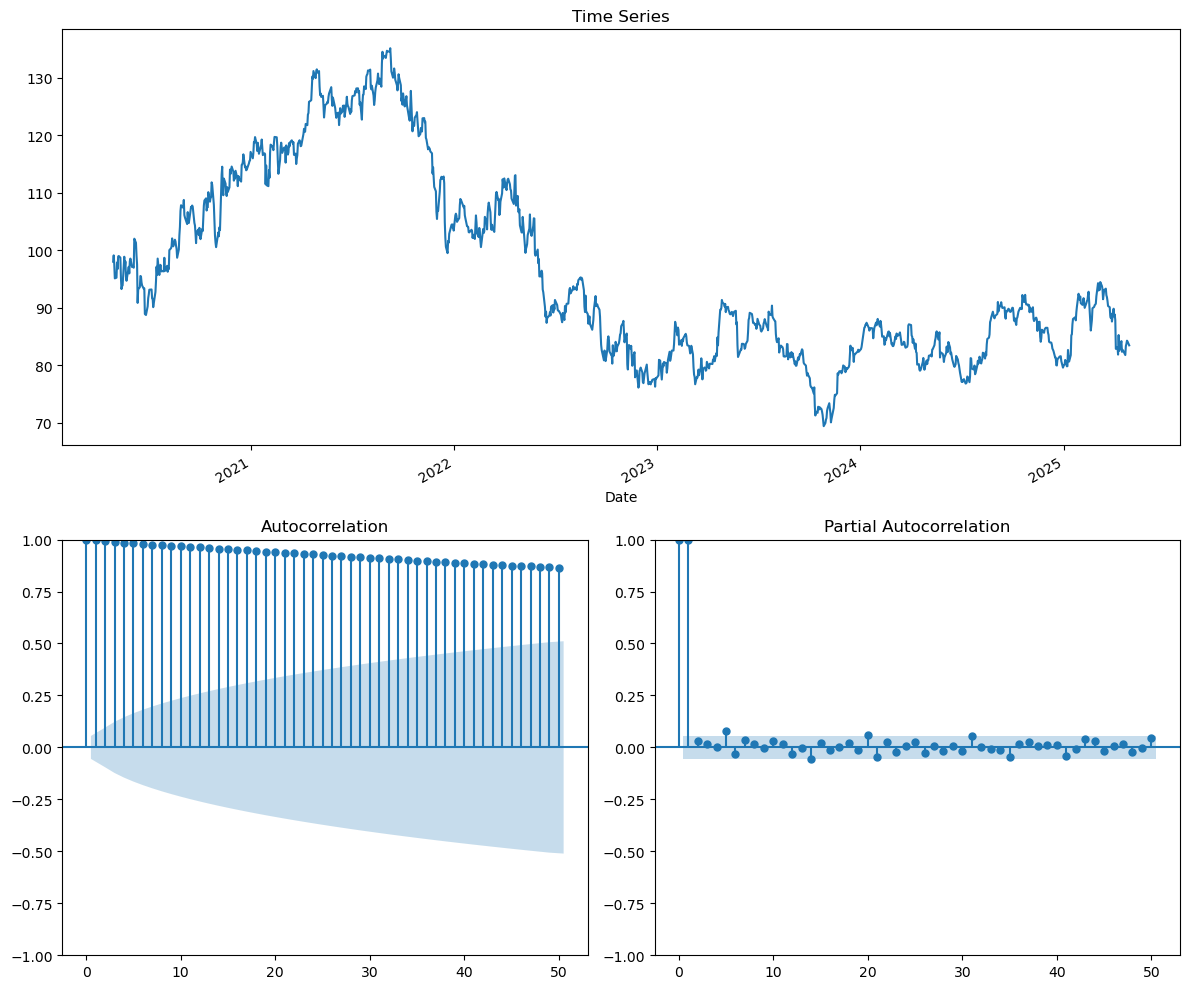

In [33]:
plotds(mdt['Close'], nlag = 100)

The first view that I got was a NO stationary according with the "autocorrelation" image.

In [34]:
# Calculate the mean value of first 125 rows and afterwards
mean1, mean2 = mdt.iloc[:125].Close.mean(), mdt.iloc[125:].Close.mean()

# Calculate the variance value of first 125 rows and afterwards
var1, var2 = mdt.iloc[:125].Close.var(), mdt.iloc[125:].Close.var()

print('mean1 = %f, mean2 = %f' % (mean1, mean2))
print('variance1 = %f, variance2 = %f' % (var1, var2))

mean1 = 99.586080, mean2 = 95.850459
variance1 = 30.661368, variance2 = 287.956444


In [35]:
from statsmodels.tsa.stattools import adfuller

# Call adfuller() function to calculate the values
adf_result = adfuller(mdt.Close.tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -1.208857
p-value: 0.669774


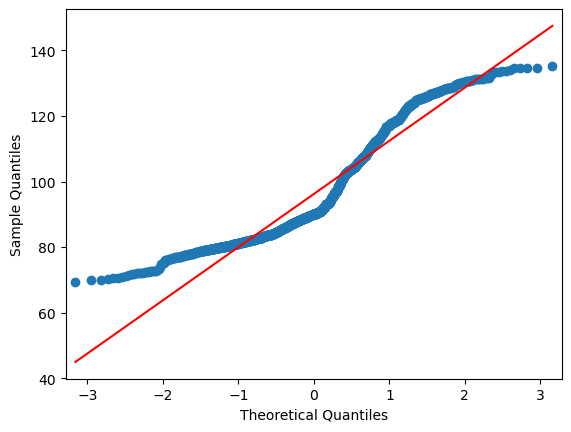

In [36]:
x = sm.qqplot(mdt['Close'], line = 's')

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# (1,1,0), which is the same than (p,d,q)

# Call ARIMA function to train the model on the 'Close' price
model = ARIMA(mdt['Close'], order = (1, 1, 0))
results_AR = model.fit()

In [38]:
# Store one difference value of the 'Close' column
first_order_diff = mdt['Close'].diff(1)
first_order_diff.head()

Date
2020-04-28     NaN
2020-04-29    1.10
2020-04-30   -1.51
2020-05-01   -2.49
2020-05-04    0.12
Name: Close, dtype: float64

In [39]:
first_order_diff = mdt['Close'].diff(1).dropna()
first_order_diff.head()

Date
2020-04-29    1.10
2020-04-30   -1.51
2020-05-01   -2.49
2020-05-04    0.12
2020-05-05    2.64
Name: Close, dtype: float64

Text(0.5, 1.0, 'First-order differences of Medtronic Stocks during Apr 2020 - Apr 2025')

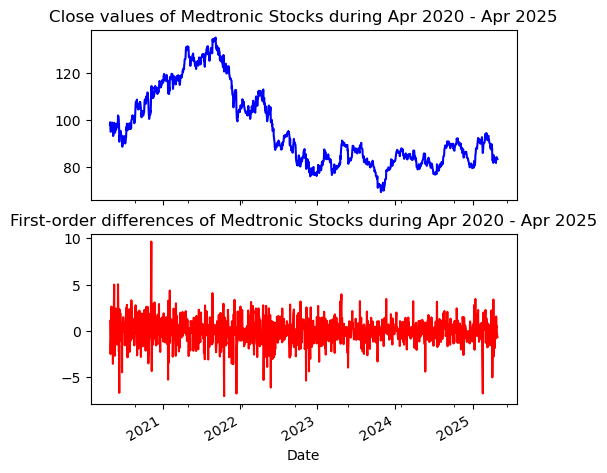

In [40]:
fig, ax = plt.subplots(2, sharex = True)
fig.set_size_inches(5.5, 5.5)
mdt['Close'].plot(ax = ax[0], color = 'b')
ax[0].set_title('Close values of Medtronic Stocks during Apr 2020 - Apr 2025')
first_order_diff.plot(ax = ax[1], color = 'r')
ax[1].set_title('First-order differences of Medtronic Stocks during Apr 2020 - Apr 2025')

ADF Statistic: -19.705688
p-value: 0.000000


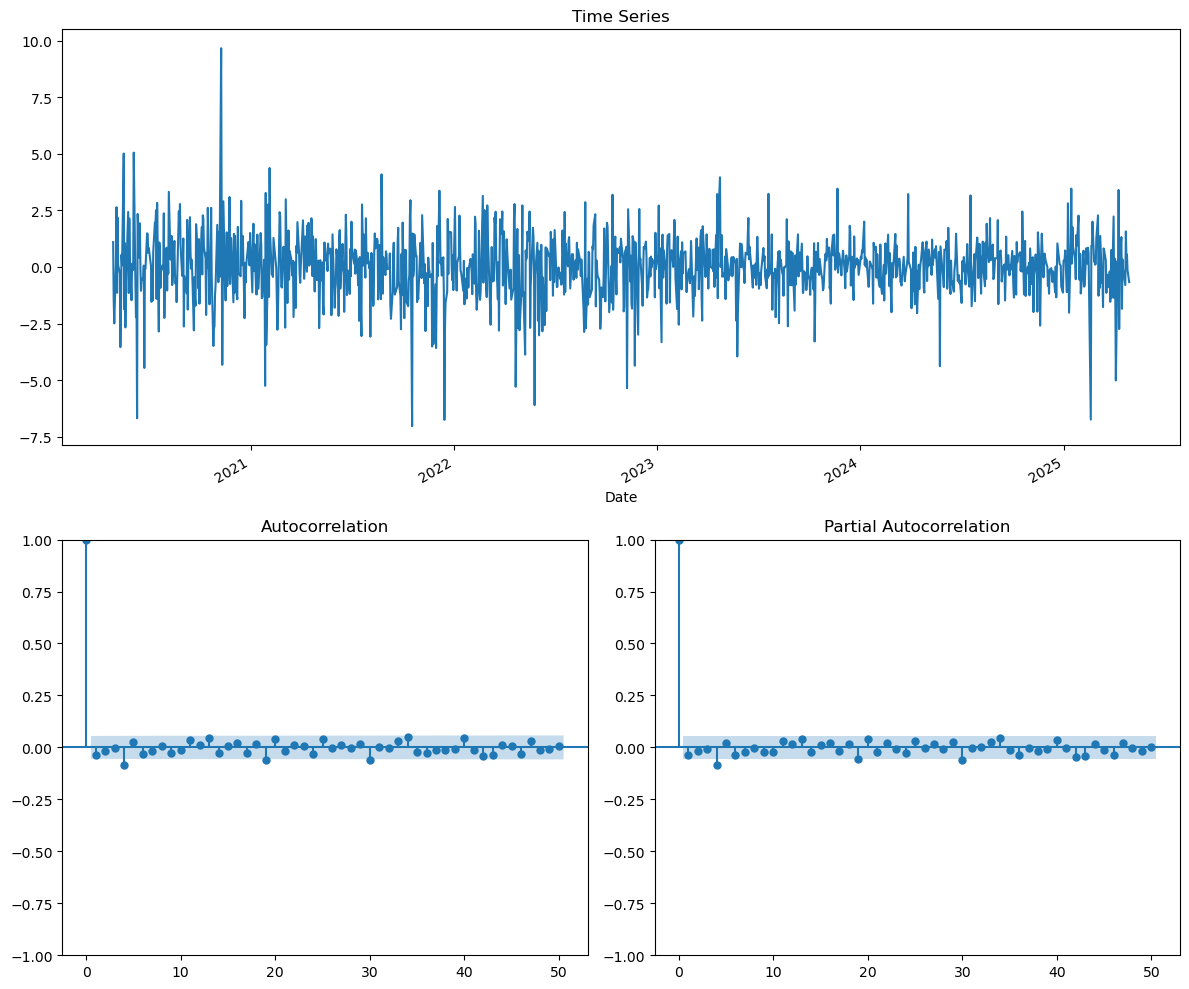

In [41]:
plotds(first_order_diff, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(first_order_diff)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

In [42]:
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(mdt['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

[[0, 1, 0, 4422.474620845525], [0, 1, 1, 4422.9005919007905], [0, 1, 2, 4424.365276754782], [1, 1, 0, 4422.960650649449], [1, 1, 1, 4421.301008868739], [1, 1, 2, 4423.204171431427], [2, 1, 0, 4424.487350793165], [2, 1, 1, 4423.279862213895], [2, 1, 2, 4423.10285510928], [0, 2, 0, 5332.272034593261], [0, 2, 1, 4429.012574440535], [0, 2, 2, 4429.511739367455], [1, 2, 0, 4960.197577336206], [1, 2, 1, 4429.555035728881], [1, 2, 2, 4431.796398124887], [2, 2, 0, 4801.99752091105], [2, 2, 1, 4431.115482533094], [2, 2, 2, 4429.682532665914]]


The samllest values here is (1,1,1) (4421.30)

In [43]:
# Declare and initialise an object 'arima_obj' by calling a method 'ARIMA()'
arima_obj = ARIMA(mdt['Close'].tolist(), order = (1, 1, 1))
arima_obj_fit = arima_obj.fit()

# Display the summary of the trained model
arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2207.651
Date:                Sun, 11 May 2025   AIC                           4421.301
Time:                        22:48:48   BIC                           4436.708
Sample:                             0   HQIC                          4427.092
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7702      0.155      4.981      0.000       0.467       1.073
ma.L1         -0.8112      0.144     -5.634      0.000      -1.093      -0.529
sigma2         1.9689      0.045     43.345      0.000       1.880       2.058
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               874.22
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# Declare the array 'pred' and append the values 
pred = arima_obj_fit.fittedvalues

# Add a new column 'ARIMA' into dataframe
mdt['ARIMA'] = pred

# Residues and fitted values are added and stored into dataframe
diffval = arima_obj_fit.resid + arima_obj_fit.fittedvalues

# Add a column 'diffval' into dataframe
mdt['diffval'] = diffval

# Display first five records
mdt.head()

,Open,High,Low,Close,Adj Close,Volume,ARIMA,diffval
Date,,,,,,,,
2020-04-28,102.36,102.49,97.82,98.04,84.93,4501000,0.000000,98.04
2020-04-29,99.50,100.79,98.73,99.14,85.88,5393600,98.039993,99.14
2020-04-30,98.13,99.44,96.85,97.63,84.57,5497000,99.098614,97.63
2020-05-01,97.00,97.18,94.60,95.14,82.41,4172000,97.655052,95.14
2020-05-04,94.53,95.70,93.61,95.26,82.52,4717600,95.258672,95.26


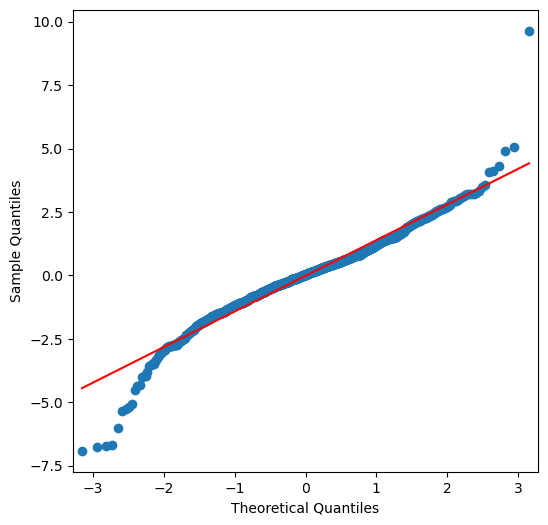

In [45]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
# Call qqplot() for arima_obj_fit
fig, ax = plt.subplots(figsize=(6, 6))

# Remove the first and last point from residuals
residuals = arima_obj_fit.resid[2:]

sm.qqplot(residuals, line='s', ax=ax)
plt.show()

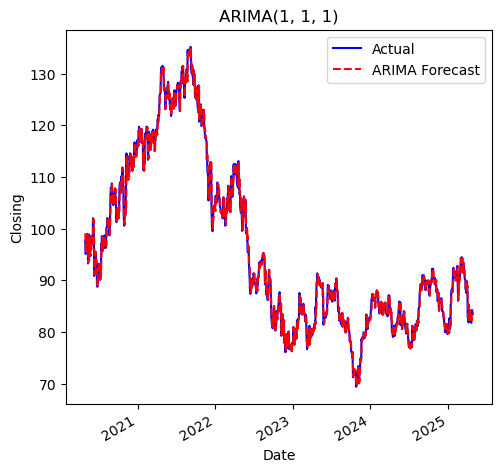

In [46]:
# Declare the objects f and array axarr
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

# Ignore first two rows because of difference factor d = 2
mdt['diffval'].iloc[2:].plot(color='b', linestyle='-', ax=axarr, label='Actual')
mdt['ARIMA'].iloc[2:].plot(color='r', linestyle='--', ax=axarr, label='ARIMA Forecast')
axarr.set_title('ARIMA(1, 1, 1)')
axarr.set_ylabel('Closing')
axarr.legend()  # Add legend

plt.show()

In [47]:
result = arima_obj_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]

for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 83.499 between 81.700 and 85.297
90.0% Confidence Interval: 83.499 between 81.191 and 85.807
95.0% Confidence Interval: 83.499 between 80.748 and 86.249
99.0% Confidence Interval: 83.499 between 79.884 and 87.113


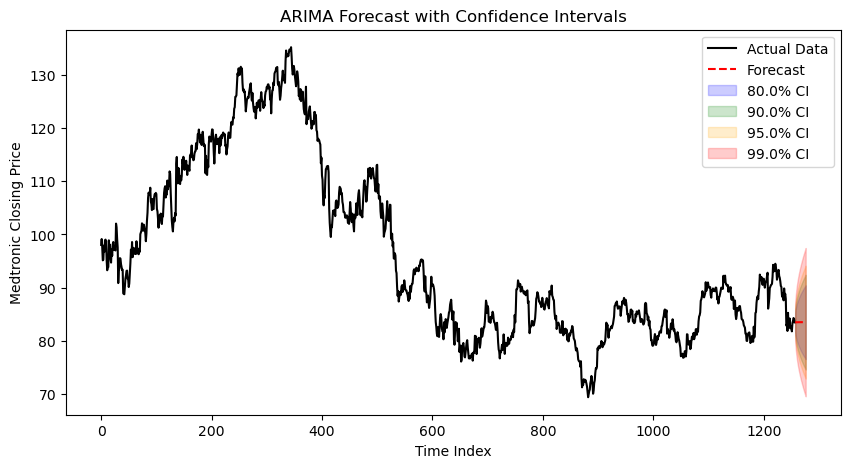

In [48]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Extract actual closing prices for ARIMA modeling
closing_prices = mdt["Close"].values

# Fit an ARIMA model (assuming a basic (1, 1, 1) model)
model = sm.tsa.ARIMA(closing_prices, order=(1, 1, 1))
arima_obj_fit = model.fit()

# Forecast next 5 points
result = arima_obj_fit.get_forecast(steps=20)
forecast = result.predicted_mean

# Define confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
colors = ['blue', 'green', 'orange', 'red']

# Extract past observed values and time indices
time_steps = np.arange(len(closing_prices))  # Time indices for actual values
future_steps = np.arange(len(closing_prices), len(closing_prices) + len(forecast))  # Forecast indices

# Plot actual observed values
plt.figure(figsize=(10, 5))
plt.plot(time_steps, closing_prices, label="Actual Data", color='black', linestyle='solid')

# Plot forecasted values
plt.plot(future_steps, forecast, label="Forecast", color='red', linestyle='dashed')

# Plot confidence intervals dynamically
for a, color in zip(intervals, colors):
    ci = result.conf_int(alpha=a)
    lower_bound, upper_bound = ci[:, 0], ci[:, 1]
    plt.fill_between(future_steps, lower_bound, upper_bound, color=color, alpha=0.2, label=f"{(1-a)*100:.1f}% CI")

# Labels and legend
plt.xlabel("Time Index")
plt.ylabel("Medtronic Closing Price")
plt.title("ARIMA Forecast with Confidence Intervals")
plt.legend()
plt.show()


# Linear Regression

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

In [50]:
mdt

,Open,High,Low,Close,Adj Close,Volume,ARIMA,diffval
Date,,,,,,,,
2020-04-28,102.36,102.49,97.82,98.04,84.93,4501000,0.000000,98.04
2020-04-29,99.50,100.79,98.73,99.14,85.88,5393600,98.039993,99.14
2020-04-30,98.13,99.44,96.85,97.63,84.57,5497000,99.098614,97.63
2020-05-01,97.00,97.18,94.60,95.14,82.41,4172000,97.655052,95.14
2020-05-04,94.53,95.70,93.61,95.26,82.52,4717600,95.258672,95.26
...,...,...,...,...,...,...,...,...
2025-04-22,82.81,83.62,82.50,83.37,83.37,5284900,81.878336,83.37
2025-04-23,84.16,85.35,83.36,83.75,83.75,6468200,83.369255,83.75
2025-04-24,84.03,84.54,83.26,84.30,84.30,5959000,83.733835,84.30


In [51]:
mdt2=mdt[["Close", "Open"]]

In [52]:
mdt2

,Close,Open
Date,,
2020-04-28,98.04,102.36
2020-04-29,99.14,99.50
2020-04-30,97.63,98.13
2020-05-01,95.14,97.00
2020-05-04,95.26,94.53
...,...,...
2025-04-22,83.37,82.81
2025-04-23,83.75,84.16
2025-04-24,84.30,84.03


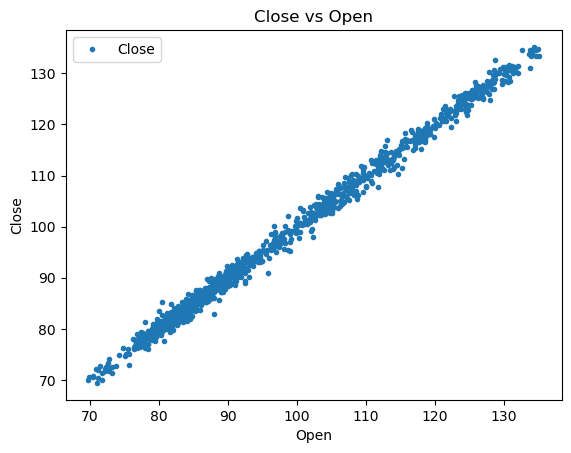

In [53]:
mdt2.plot(x='Open', y='Close', style='.')
plt.title('Close vs Open')
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

In [54]:
X = mdt2[["Open"]].values            # Independent variables
Y = mdt2[["Close"]].values              # Dependent variable

In [55]:
print (X,Y)

[[102.36]
 [ 99.5 ]
 [ 98.13]
 ...
 [ 84.03]
 [ 84.41]
 [ 84.6 ]] [[98.04]
 [99.14]
 [97.63]
 ...
 [84.3 ]
 [84.16]
 [83.49]]


In [56]:
# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [57]:
# Show the rows and columns
X.shape, Y.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1257, 1), (1257, 1), (1005, 1), (252, 1), (1005, 1), (252, 1))

In [58]:
# Method to calculate the score
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             Y_train,
                             cv = 10,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [59]:
# Train the model
lr = LinearRegression().fit(X_train, Y_train)

# Calculate the mean values and Standard deviation
get_cv_scores(lr)

CV Mean:  0.9951159533292108
STD:  0.0009427377057910655




In [60]:
# Calculate the intercept and coefficient
print(lr.intercept_)
print(lr.coef_)

[0.33229389]
[[0.99606309]]


In [61]:
# Predicted values
Y_pred = lr.predict(X_test)
Y_pred

array([[ 96.74123989],
       [111.5626586 ],
       [ 91.28281419],
       [ 83.50356149],
       [117.568919  ],
       [ 95.47623978],
       [130.35836902],
       [103.89297285],
       [124.73061259],
       [ 93.24505847],
       [ 82.06923065],
       [ 87.97588475],
       [ 81.96962434],
       [100.90478359],
       [ 79.74840366],
       [ 84.56934899],
       [ 89.07155414],
       [ 86.50171138],
       [104.37108313],
       [ 80.51537224],
       [ 89.06159351],
       [109.26175287],
       [ 82.00946687],
       [111.9511232 ],
       [ 86.16304993],
       [117.86773793],
       [ 84.68887656],
       [ 70.48501697],
       [104.61013827],
       [ 81.31222271],
       [114.21218641],
       [ 86.34234129],
       [ 89.97797155],
       [ 91.75096384],
       [ 88.4141525 ],
       [ 71.55080447],
       [ 82.25848264],
       [ 88.43407376],
       [106.11419353],
       [124.6708488 ],
       [127.13112462],
       [ 79.51930915],
       [ 83.00552995],
       [ 87

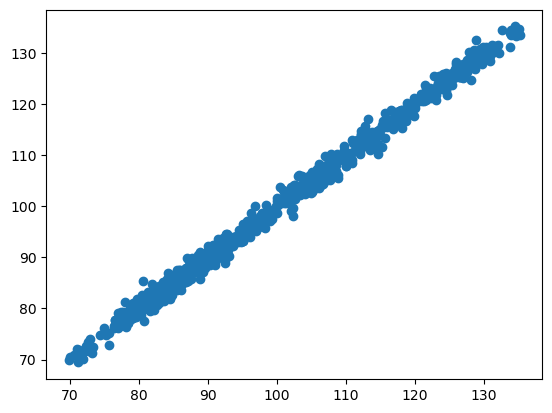

In [62]:
plt.scatter(X_train[:, 0], Y_train)

In [63]:
# Display the test and predicted values
df = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})
df.head()

,Actual,Predicted
0,97.90,96.741240
1,110.58,111.562659
2,92.77,91.282814
3,83.70,83.503561
4,116.58,117.568919


## Cross Validation

In [64]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Linear Regression
linear_reg = LinearRegression()
lr = linear_reg.fit(X_train, Y_train)

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# k-fold CV (using all variables)
scores = cross_val_score(lr, X_train, Y_train, scoring = 'r2', cv = 10)
print(scores, scores.mean())

[0.99522541 0.99558422 0.99601606 0.99537637 0.99387617 0.9942517
 0.99607062 0.99348022 0.99481497 0.99646379] 0.9951159533292108


In [66]:
print(f"Mean R²: {scores.mean():.3f}")

Mean R²: 0.995


## Time Series Split

In [67]:
from sklearn.model_selection import TimeSeriesSplit

In [68]:
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

In [69]:
X = mdt2[["Open"]]   
y = mdt2[["Close"]]    

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"R²: {score:.3f}")

R²: 0.971
R²: 0.981
R²: 0.938
R²: 0.967
R²: 0.947


## Hyperparameter

In [70]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model = Ridge()
param_grid = {'alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=5))
grid_search.fit(X, y)
print("Best alpha:", grid_search.best_params_)

Best alpha: {'alpha': 0}


# K-means Clustering

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [72]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(mdt2[['Close', 'Open']])

In [73]:
def perform_clustering(n_clusters, mdt2):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(mdt2)
    db_index = davies_bouldin_score(mdt2, labels)
    silhouette_avg = silhouette_score(mdt2, labels)
    return db_index, silhouette_avg

In [74]:
cluster_range = range(2, 11)
db_scores = []
silhouette_scores = []

for n_clusters in cluster_range:
    db_index, silhouette_avg = perform_clustering(n_clusters, mdt2)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

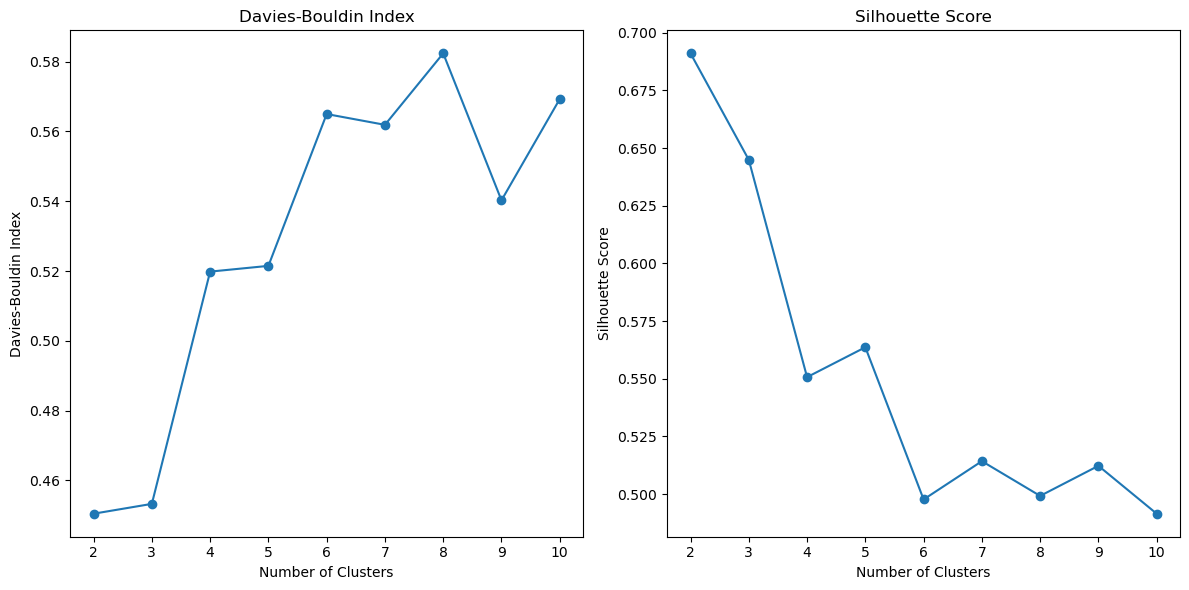

In [75]:
# Plot the Davies-Bouldin Index
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

# Plot the Silhouette Score Method
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

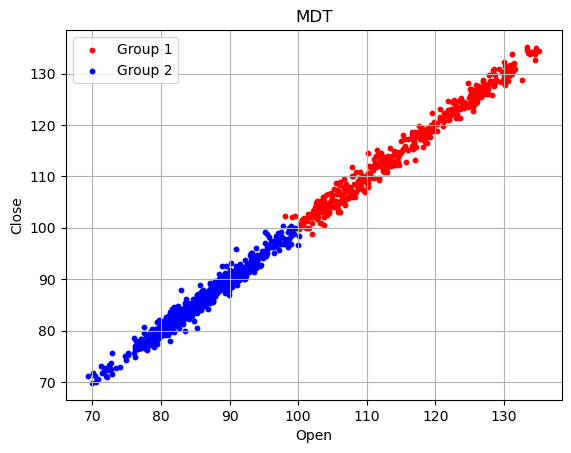

In [76]:
hc = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(mdt2)
plt.scatter(mdt2.values[y_hc == 0, 0], mdt2.values[y_hc == 0, 1], s = 10, c = 'red', label = 'Group 1')
plt.scatter(mdt2.values[y_hc == 1, 0], mdt2.values[y_hc == 1, 1], s = 10, c = 'blue', label = 'Group 2')
plt.title('MDT')
plt.xlabel('Open')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, max_iter = 300, n_init = 10, random_state = 38)
y_kmeans = kmeans.fit_predict(mdt2)

In [78]:
mdt2.head()

,Close,Open
Date,,
2020-04-28,98.04,102.36
2020-04-29,99.14,99.50
2020-04-30,97.63,98.13
2020-05-01,95.14,97.00
2020-05-04,95.26,94.53


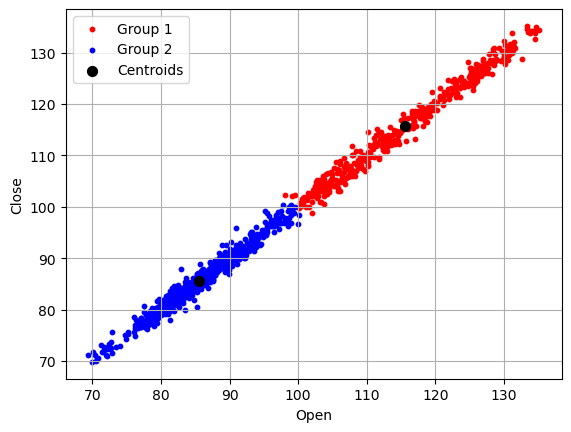

In [79]:
plt.scatter(mdt2.values[y_hc == 0, 0], mdt2.values[y_hc == 0, 1], s = 10, c = 'red', label = 'Group 1')
plt.scatter(mdt2.values[y_hc == 1, 0], mdt2.values[y_hc == 1, 1], s = 10, c = 'blue', label = 'Group 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 50, c = 'black', label = 'Centroids')
plt.xlabel('Open')
plt.ylabel('Close')
plt.grid(True)
plt.legend( loc ="best");

# K-Nearest Neighbours

In [80]:
mdt2.head()

,Close,Open
Date,,
2020-04-28,98.04,102.36
2020-04-29,99.14,99.50
2020-04-30,97.63,98.13
2020-05-01,95.14,97.00
2020-05-04,95.26,94.53


In [81]:
X = mdt2.iloc[:-1, [0, 1]].values  # 0 is Close, 1 is Open based on head()

y = mdt2.iloc[1:, 0].values  # Next day's Close price

In [82]:
#Training and Testing Data (divide the data into two part)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size= 0.25, random_state=0)

# print(X_train)

In [83]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [84]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, metric="minkowski", p=2)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions using the regression model
y_predict = knn.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")



Mean Squared Error: 2.4450
Mean Absolute Error: 1.1331
R² Score: 0.9901


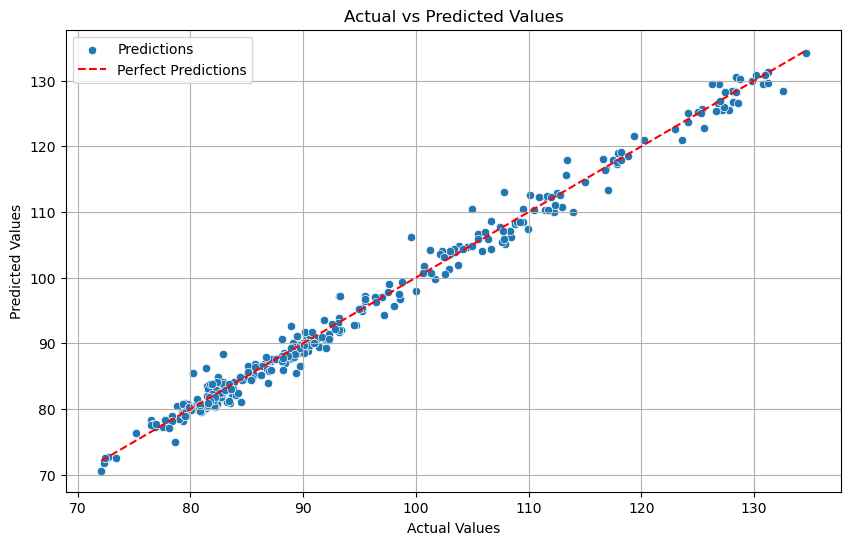

In [94]:
# scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_predict, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Predictions")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Simple Exponential Smoothing

In [ ]:
# Load all related libraries
import esFunctions as es
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import axes

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [ ]:
mdto = mdt.reset_index()

In [ ]:
mdto.head()

In [ ]:
mdto2=mdto[["Date", "Close"]]

In [ ]:
mdto2.head()

In [ ]:
# Add a new column (SES) in the dataframe
mdto2['SES'] = es.single_exp_smoothing(mdto2['Close'], 0.99)

# Display first five records
mdto2

In [ ]:
# plot the above dataframe
fig = plt.figure(figsize = (5.5, 5.5))
ax = fig.add_subplot(2, 1, 1)
fig.subplots_adjust(hspace = 0.5)
mdto2['Close'].plot(ax = ax)
ax.set_title('Medtronic Common Stock Close Prices during 2020-2025')
ax = fig.add_subplot(2, 1, 2)
mdto2['SES'].plot(ax = ax, color = 'r')
ax.set_title('Single Exponential Smoothing')

# Save the png file on your folder
plt.savefig('_02_1.png', format = 'png', dpi = 300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot the above dataframe
fig, ax = plt.subplots(figsize = (5.5, 5.5))
fig.subplots_adjust(hspace = 0.5)

mdto2['Close'].plot(ax = ax, label = 'Medtronic Common Stock Close Prices')
mdto2['SES'].plot(ax = ax, color = 'r', label = 'Single Exponential Smoothing')

ax.set_title('IBM Common Stock Close Prices and Single Exponential Smoothing')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Save the png file in your folder
plt.savefig('_02_1.png', format = 'png', dpi =300)
plt.show()

In [ ]:
# Comapre Single exponential smooting for three values of alpha (0.2, 0.6, 0.8)
mdto2['SES2'] = es.single_exp_smoothing(mdto2['Close'], 0.2)
mdto2['SES6'] = es.single_exp_smoothing(mdto2['Close'], 0.6)
mdto2['SES8'] = es.single_exp_smoothing(mdto2['Close'], 0.8)
mdto2['SES10'] = es.single_exp_smoothing(mdto2['Close'], 1)

In [ ]:
# plot three figures for three values of alpha
f, axarr = plt.subplots(3, sharex = True)
f.set_size_inches(5.5, 5.5)

mdto2['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0])
mdto2['SES2'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title('Alpha 0.2')

mdto2['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1])
mdto2['SES6'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[1])
axarr[1].set_title('Alpha 0.6')

mdto2['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[2])
mdto2['SES8'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[2])
axarr[2].set_title('Alpha 0.8')

mdto2['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[2])
mdto2['SES10'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[2])
axarr[2].set_title('Alpha 1')
plt.savefig('_02_02.png', format='png', dpi=300)

# References

• Auffarth, B. (2021) Machine Learning for Time-Series with Python. Birmingham: Packt Publishing.

• Brownlee, J. (Year) Time Series Forecast Uncertainty Using Confidence Intervals in Python [Online]. Available at: https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/

• Pal, A. and Prakash, P.K.S. (2017) ‘Chapter 4, in Practical Time Series Analysis. Birmingham: Packt Publishing, pp. [page range if available].

• Peixeiro, M. (2022) Time Series Forecasting in Python. Shelter Island, NY: Manning Publications.

* <p>https://github.com/mGalarnyk/Python_Tutorials</p>
* <p>https://medium.com/analytics-vidhya/linear-regression-in-python-with-scikit-learn-e1bb8a059cd2</p>
* Python for Machine Learning - The Complete Beginner's Course, Meta Brains, Packt Publishing, September 2022.
https://www.datacamp.com/community/tutorials/introduction-machine-learning-python

https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55